Load Esophagus Cancer Data

In [1]:
import numpy as np
dataset_train = np.loadtxt('lung.csv',delimiter=',')
dataset_test = np.loadtxt('lung_test.csv',delimiter=',')

Split Label and Data

In [2]:
X_train = dataset_train[:,1:]
y_train = dataset_train[:,0]
X_test = dataset_test[:,1:]
y_test = dataset_test[:,0]

Create SVM Model and Perform GridSearch with 10-CV Train Accuracy

In [49]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
clf = SVC()
parameters = {'C':[1,2,4,8,16],
              'gamma':[2**(-4),2**(-3),2**(-2),2**(-1),0,1,2,4,8]}
clf = GridSearchCV(clf,parameters,scoring='accuracy',cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 4, 8, 16], 'gamma': [0.0625, 0.125, 0.25, 0.5, 0, 1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Check Best Parameters

In [51]:
clf.best_params_

{'C': 8, 'gamma': 0.0625}

Check Best 10-CV Training Accuracy

In [52]:
clf.best_score_

0.555379746835443

Check Test Accuracy

In [66]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.5845588235294118

# Feature Selection

## Remove Low Variance Features

If features having nearly constant or almost the same values for each sample data form different labels, this features is meaningless and should be remove 

In [3]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
sel.fit(X_train)
X_train_sel = sel.transform(X_train)
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(632, 734)

Try perform Grid-Search again

In [55]:
clf = SVC()
parameters = {'C':[1,2,4,8,16],
              'gamma':[2**(-4),2**(-3),2**(-2),2**(-1),0,1,2,4,8,16]}
clf = GridSearchCV(clf,parameters,scoring='accuracy',cv=10)
clf.fit(X_train_sel, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 4, 8, 16], 'gamma': [0.0625, 0.125, 0.25, 0.5, 0, 1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Check best parameters

In [56]:
clf.best_params_

{'C': 8, 'gamma': 0.0625}

Check best 10-CV Training Accuracy

In [57]:
clf.best_score_

0.5537974683544303

Check Test Accuracy

In [62]:
y_pred = clf.predict(X_test_sel)
accuracy_score(y_test, y_pred)

0.6066176470588235

## Filter Method

Select feature based-on external measurement of each features between different labels and try to find feature that significantly different between labels such as chi2, F-Score or Mutual Information

Use SelectionKBest to select 80 Best feature based-on F-Score

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
sel2 = SelectKBest(f_classif, k=80)
X_train_sel2 = sel2.fit(X_train_sel,y_train)
X_train_sel2 = sel2.transform(X_train_sel)
X_test_sel2 = sel2.transform(X_test_sel)
X_train_sel2.shape

(632, 80)

Try to perform Grid-Search again

In [75]:
clf = SVC()
parameters = {'C':[1,2,4,8,16],
              'gamma':[2**(-4),2**(-3),2**(-2),2**(-1),0,1,2,4,8,16]}
clf = GridSearchCV(clf,parameters,scoring='accuracy',cv=10)
clf.fit(X_train_sel2, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 4, 8, 16], 'gamma': [0.0625, 0.125, 0.25, 0.5, 0, 1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Check best parameters

In [76]:
clf.best_params_

{'C': 2, 'gamma': 0.0625}

Check best 10-CV Training Accuracy

In [78]:
clf.best_score_

0.564873417721519

Check Test Accuracy

In [79]:
y_pred = clf.predict(X_test_sel2)
accuracy_score(y_test, y_pred)

0.6470588235294118

## Wrapper Method

Evaluated best set of features based on model performance

Using Feed Forward Feature Selection to choose features based on SVM 10-CV Training Accuracy Performance

**Note: This is my own Feed Forward Feature Selection Function

In [287]:
from sklearn.model_selection import cross_val_score
def FF_selection(clf, X, y, cv, k):
    feature_choose = []
    feature_index = list(range(0,X.shape[1]))
    while(len(feature_choose) != k):
        feature_accuracy = [cross_val_score(clf, X[:,feature_choose+[i]], y, cv = cv, 
                                            scoring = 'accuracy').mean() for i in feature_index]
        current_max_index = np.argmax(feature_accuracy)
        feature_choose.append(feature_index[current_max_index])
        feature_index.pop(current_max_index)
    return feature_choose, feature_accuracy[current_max_index]

Creat simple SVM model to perform feature selection

In [288]:
clf = SVC(C=1, gamma='auto')
feature_choose, accuracy = FF_selection(clf, X_train_sel2, y_train, 10, 10)

Check choosing features

In [294]:
feature_choose

[14, 30, 19, 51, 38, 35, 11, 62, 45, 74]

Check 10-CV Training Accuracy

In [292]:
clf = SVC(C=1, gamma='auto')
cross_val_score(clf,X_train_sel2[:,feature_choose], y_train, cv = 10, scoring = 'accuracy').mean()

0.6208701356886841

Check Test Accuracy

In [295]:
clf.fit(X_train_sel2[:,feature_choose], y_train)
y_pred = clf.predict(X_test_sel2[:,feature_choose])
accuracy_score(y_test, y_pred)

0.6433823529411765

Optimize parameters by grid search

In [296]:
clf = SVC()
parameters = {'C':[1,2,4,8,16],
              'gamma':[2**(-4),2**(-3),2**(-2),2**(-1),0,1,2,4,8,16]}
clf = GridSearchCV(clf,parameters,scoring='accuracy',cv=10)
clf.fit(X_train_sel2[:, feature_choose], y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 4, 8, 16], 'gamma': [0.0625, 0.125, 0.25, 0.5, 0, 1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [299]:
clf.best_params_

{'C': 2, 'gamma': 0.0625}

In [300]:
clf.best_score_

0.6186708860759493

In [301]:
y_pred = clf.predict(X_test_sel2[:, feature_choose])
accuracy_score(y_test, y_pred)

0.6617647058823529

Ex 1. Write program to perform Backward Feature Selection
1. Start with all features
2. Try to remove features 1 by 1 to find a best removing feature
3. If number of features = k Then end Else go to 2.
   
Hint: use set to subtract list

In [284]:
def BW_selection(clf, X, y, cv, k):
    feature_index = """ ### Your Code ### """
    while(len(feature_index) != k):
        feature_accuracy = [cross_val_score(clf, X[:, """ ### Your Code ### """ ], y, cv = cv, 
                                            scoring = 'accuracy').mean() for i in feature_index]
        """ ### Your Code ### """
        """ ### Your Code ### """
    return feature_index, feature_accuracy[current_max_index]

In [302]:
clf = SVC(C=1, gamma='auto')
feature_index, accuracy = BW_selection(clf, X_train_sel2, y_train, 10,50)

In [305]:
len(feature_index)

50

In [306]:
accuracy

0.6034554211469534

# Deep Learning using Keras

Neural Network vs. Deep Learning Network

![Deep](https://ackstorm.com/wp-content/uploads/2019/02/deep-learning.png)

Component of neural network

![component](https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png)

Activation Function

https://en.wikipedia.org/wiki/Activation_function

## Keras

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. 

![Keras](https://raw.github.com/plenoi/CMU_DataScience/master/keras.png)

Install Keras by <br>
1. Open Anaconda-Navigator <br>
2. Create new environment called "Keras" using python 3.5 <br>
3. Install Keras 

Load Keras component for create model & KerasClassifier to work with Scikit-Learn

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Create Deep Learning model <br> 
Model Type = Sequential <br>
Model Config = [734, 12, 8, 1] <br>
Binary Classifier Config

In [13]:
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=X_train_sel.shape[1], activation='relu') )
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

Create Model with training configuration <br>
epochs = 200 <br>
batch_size = 20

In [14]:
clf = KerasClassifier(build_fn=create_model, epochs=200, batch_size=20)

Train Deep Learning Model

In [15]:
clf.fit(X_train_sel, y_train)

Epoch 1/200
632/632 [==============================] - 0s 728us/step - loss: 0.6993 - acc: 0.4968
Epoch 2/200
632/632 [==============================] - 0s 79us/step - loss: 0.6864 - acc: 0.5823
Epoch 3/200
632/632 [==============================] - 0s 76us/step - loss: 0.6756 - acc: 0.6123
Epoch 4/200
632/632 [==============================] - 0s 82us/step - loss: 0.6724 - acc: 0.6076
Epoch 5/200
632/632 [==============================] - 0s 84us/step - loss: 0.6677 - acc: 0.6250
Epoch 6/200
632/632 [==============================] - 0s 82us/step - loss: 0.6613 - acc: 0.6108
Epoch 7/200
632/632 [==============================] - 0s 98us/step - loss: 0.6580 - acc: 0.6234
Epoch 8/200
632/632 [==============================] - 0s 82us/step - loss: 0.6556 - acc: 0.6218
Epoch 9/200
632/632 [==============================] - 0s 112us/step - loss: 0.6509 - acc: 0.6203
Epoch 10/200
632/632 [==============================] - 0s 81us/step - loss: 0.6452 - acc: 0.6313
Epoch 11/200
632/632 [=====

632/632 [==============================] - 0s 122us/step - loss: 0.5800 - acc: 0.6851
Epoch 85/200
632/632 [==============================] - 0s 98us/step - loss: 0.5685 - acc: 0.6899
Epoch 86/200
632/632 [==============================] - 0s 82us/step - loss: 0.5799 - acc: 0.6851
Epoch 87/200
632/632 [==============================] - 0s 95us/step - loss: 0.5754 - acc: 0.6661
Epoch 88/200
632/632 [==============================] - 0s 84us/step - loss: 0.5642 - acc: 0.6946
Epoch 89/200
632/632 [==============================] - 0s 95us/step - loss: 0.5796 - acc: 0.6677
Epoch 90/200
632/632 [==============================] - 0s 108us/step - loss: 0.5678 - acc: 0.7120
Epoch 91/200
632/632 [==============================] - 0s 103us/step - loss: 0.5753 - acc: 0.6677
Epoch 92/200
632/632 [==============================] - 0s 84us/step - loss: 0.5683 - acc: 0.6883
Epoch 93/200
632/632 [==============================] - 0s 89us/step - loss: 0.5805 - acc: 0.6867
Epoch 94/200
632/632 [========

Epoch 167/200
632/632 [==============================] - 0s 68us/step - loss: 0.5355 - acc: 0.7104
Epoch 168/200
632/632 [==============================] - 0s 65us/step - loss: 0.5379 - acc: 0.7025
Epoch 169/200
632/632 [==============================] - 0s 62us/step - loss: 0.5231 - acc: 0.7247
Epoch 170/200
632/632 [==============================] - 0s 66us/step - loss: 0.5366 - acc: 0.7215
Epoch 171/200
632/632 [==============================] - 0s 63us/step - loss: 0.5323 - acc: 0.7231
Epoch 172/200
632/632 [==============================] - 0s 70us/step - loss: 0.5272 - acc: 0.7215
Epoch 173/200
632/632 [==============================] - 0s 62us/step - loss: 0.5361 - acc: 0.7073
Epoch 174/200
632/632 [==============================] - 0s 71us/step - loss: 0.5335 - acc: 0.7136
Epoch 175/200
632/632 [==============================] - 0s 81us/step - loss: 0.5296 - acc: 0.7120
Epoch 176/200
632/632 [==============================] - 0s 76us/step - loss: 0.5328 - acc: 0.7104
Epoch 177/

## Loss & Accuracy
Loss is often used in the training process to find the "best" parameter values for your model <br>
Accuracy is when you apply model using the optimized parameters above to see how accurate of your model

Check Loss Trend

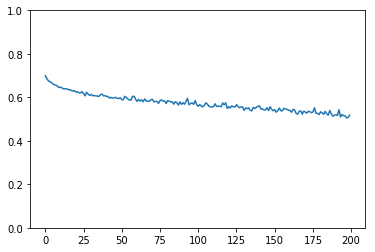

In [54]:
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(clf.model.history.history['loss'])

Check Accuracy Trend

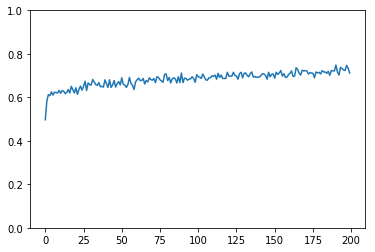

In [55]:
clf.model.history.history['acc']
plt.ylim(0, 1)
plt.plot(clf.model.history.history['acc'])

Test our Deep Learning Model

In [23]:
y_pred = clf.predict(X_test_sel)
accuracy_score(y_test, y_pred)

0.6286764705882353

## Convolution Neural Network

CNN are biologically-inspired from the animal visual cortex and CNN considered to be one kinds of multilayer perceptions. In animal visual cortex, each neuron cell is responsible for a small sub-regions of the visualisation called a receptive field. The receptive fields of different neurons are combined and partially overlapped to make it cover the all area of visualization. 

![CNN](https://raw.github.com/plenoi/CMU_DataScience/master/convolutional_neural_network.png)

![CNN2](https://raw.github.com/plenoi/CMU_DataScience/master/cnn.png)

Load digits image dataset from sklearn

In [50]:
from sklearn import datasets
digit = datasets.load_digits()
X = digit.images
y = digit.target
X.shape

(1797, 8, 8)

Split Train & Test

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_test.shape

(360, 8, 8)

Load skimage library for image processing

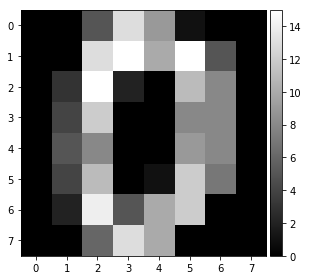

In [52]:
from skimage import io
io.imshow(X[0], cmap='gray')
io.show()

Create CNN model

In [66]:
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten
from keras import backend as K
def create_cnn_model(h,w):
    K.set_image_dim_ordering('th')
    model = Sequential()
    model.add(Convolution2D(32,(3,3), activation='relu', input_shape=(1,h,w)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])
    return model

Reshape input data to 1 channel images

In [67]:
h = 8
w = 8
X_train = X_train.reshape(X_train.shape[0],1,h,w)
X_test = X_test.reshape(X_test.shape[0],1,h,w)

Create CNN Classifier

In [68]:
clf = KerasClassifier(build_fn = create_cnn_model, h=h, w=w, epochs=5, batch_size=20)

Change label to Neural Network friendly format (Dummy Coding, OneHotEncoder)

In [82]:
from keras.utils import np_utils
y_train_oh = np_utils.to_categorical(y_train)
y_test_oh = np_utils.to_categorical(y_test)

Train model

In [88]:
clf.fit(X_train, y_train_oh)

Epoch 1/5
1437/1437 [==============================] - 1s 618us/step - loss: 2.2514 - acc: 0.2477
Epoch 2/5
1437/1437 [==============================] - 0s 275us/step - loss: 1.6213 - acc: 0.4356
Epoch 3/5
1437/1437 [==============================] - 0s 262us/step - loss: 1.2166 - acc: 0.5839
Epoch 4/5
1437/1437 [==============================] - 0s 305us/step - loss: 0.9944 - acc: 0.6667
Epoch 5/5
1437/1437 [==============================] - 0s 317us/step - loss: 0.8138 - acc: 0.7265


Continue Training

In [89]:
clf.model.fit(X_train, y_train_oh, epochs=10)

Epoch 1/10
1437/1437 [==============================] - 0s 265us/step - loss: 0.6996 - acc: 0.7648
Epoch 2/10
1437/1437 [==============================] - 0s 230us/step - loss: 0.6027 - acc: 0.7996
Epoch 3/10
1437/1437 [==============================] - 0s 220us/step - loss: 0.5870 - acc: 0.7996
Epoch 4/10
1437/1437 [==============================] - 0s 225us/step - loss: 0.5358 - acc: 0.8260
Epoch 5/10
1437/1437 [==============================] - 0s 266us/step - loss: 0.5018 - acc: 0.8372
Epoch 6/10
1437/1437 [==============================] - 0s 241us/step - loss: 0.4340 - acc: 0.8664
Epoch 7/10
1437/1437 [==============================] - 0s 229us/step - loss: 0.4343 - acc: 0.8636
Epoch 8/10
1437/1437 [==============================] - 0s 221us/step - loss: 0.3628 - acc: 0.8831
Epoch 9/10
1437/1437 [==============================] - 0s 242us/step - loss: 0.3981 - acc: 0.8782
Epoch 10/10
1437/1437 [==============================] - 0s 237us/step - loss: 0.3440 - acc: 0.8914


Try Test Result

In [90]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9777777777777777

Ex.3 Find Best Model for Esophagus Cancer Prediction <br>
You must have 10-CV Training Accuracy & Test Accuracy

Ex.4 Find Best Model for Digits Image Prediction using CNN <br>
You must have 10-CV Training Accuracy & Test Accuracy <br>
Hint : Same as Scikit Learn

## Save Scikit Learn Model

Ex.5 Write code to store Scikit Learn Classifier Model (Model Persistence)

## Load Scikit Learn Model
Ex.6 Write code to load Scikit Learn Classifier Model

## Save Deep Learning Model
Store Architecture of Model

In [92]:
json_model = clf.model.to_json()
open('model_architecture.json', 'w').write(json_model)

2696

Store Weight of Model

In [93]:
clf.model.save_weights('model_weights.h5', overwrite=True)

Store Classes

In [105]:
import pickle
pickle.dump(clf.classes_, open('classes.pkl','wb'))

## Load Deep Learning Model
Load Model & Weight

In [94]:
from keras.models import model_from_json
model = model_from_json(open('model_architecture.json').read())
model.load_weights('model_weights.h5')

Compile Model

In [95]:
model.compile(loss='categorical_crossentropy', optimizer='sgd')

Create Model & Load Classes

In [106]:
clf2 = KerasClassifier(build_fn = create_cnn_model, h=h, w=w, epochs=5, batch_size=20)
clf2.model = model
clf2.classes_ = pickle.load(open('classes.pkl','rb'))

Try Test Result

In [107]:
y_pred = clf2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9777777777777777